In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
from collections import Counter
import numpy as np
import psycopg2
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.style as mplstyle
import matplotlib.patches as mpatches
from matplotlib.ticker import (PercentFormatter,MultipleLocator, AutoMinorLocator)
import seaborn as sns

In [2]:
conn = psycopg2.connect(database="postgres",
                        host="pklmartdb.ckkvdwandqoa.us-east-1.rds.amazonaws.com",
                        user="cmcnicholas",
                        password="momentum101",
                        port="5432")
conn.autocommit = True

In [117]:
def pullawsdata2(tablename):
    pdict = {"rally":{"query":"SELECT game_id, rally_id, rally_nbr, srv_team_id, w_team_id, to_team_id FROM pklm_prd.rally;", \
             "cols":['game_id', 'rally_id', 'rally_nbr', 'srv_team_id', 'w_team_id', 'to_team_id']}, \
    "team":{"query":"SELECT team_id,team_nm FROM pklm_prd.team;", \
             "cols": ['team_id','team_nm']}, \
    "game":{"query":"SELECT match_id,game_id,game_nbr,score_w,score_l,w_team_id,l_team_id,skill_lvl,vod_url FROM pklm_prd.game;", \
             "cols":['match_id','game_id','game_nbr','score_w','score_l','w_team_id','l_team_id','skill_lvl','vod_url']}}
    qry = pdict[tablename]["query"]
    cls = pdict[tablename]["cols"]
    
    with conn,conn.cursor() as cursor:
        try:
            cursor.execute(qry)
            data=cursor.fetchall()
            return(pd.DataFrame(data,columns=cls))
        except Exception as inst:
            print(f"inst \t type: {type(inst)} \t args: {inst.args}\n")     

In [3]:
def pullrally():
    with conn,conn.cursor() as cursor:
        try:
            cursor.execute(f"SELECT game_id, rally_id, rally_nbr, srv_team_id, w_team_id, to_team_id FROM pklm_prd.rally;")
            data=cursor.fetchall()
            return(pd.DataFrame(data,columns=['game_id', 'rally_id', 'rally_nbr', 'srv_team_id', 'w_team_id', 'to_team_id']))
        except Exception as inst:
            print(type(inst))    
            print(inst.args)     
            print(inst)

In [4]:
def pullgame():
    with conn,conn.cursor() as cursor:
        try:
            cursor.execute(f"SELECT match_id,game_id,game_nbr,score_w,score_l,w_team_id,l_team_id,skill_lvl FROM pklm_prd.game;")
            data=cursor.fetchall()
            return(pd.DataFrame(data,columns=['match_id','game_id','game_nbr','score_w','score_l','w_team_id','l_team_id','skill_lvl']))
        except Exception as inst:
            print(type(inst))    
            print(inst.args)     
            print(inst)

In [5]:
def pullteam():
    with conn,conn.cursor() as cursor:
        try:
            cursor.execute(f"SELECT team_id,team_nm FROM pklm_prd.team;")
            data=cursor.fetchall()
            return(pd.DataFrame(data,columns=['team_id','team_nm']))
        except Exception as inst:
            print(type(inst))    
            print(inst.args)     
            print(inst)

In [6]:
rally=pullrally()
rally['game_id'] = [int(x[1:]) for x in rally.game_id]
rally['rally_id'] = [int(x[1:]) for x in rally.rally_id]
rally = rally.sort_values(['game_id', 'rally_id', 'rally_nbr']).reset_index(drop=True)

In [7]:
game=pullgame()
game['game_id'] = [int(x[1:]) for x in game.game_id]
game['match_id'] = [int(x[1:]) for x in game.match_id]
game.skill_lvl.iloc[game.skill_lvl == '4'] = '4.0'
game.skill_lvl.iloc[game.skill_lvl == '5'] = '5.0'
game = game.sort_values(['match_id','game_id']).reset_index(drop=True)

In [8]:
glist = list(rally.game_id.unique())
dlist = []
b2bl = []
for i in range(len(glist)):
    gi = rally[rally.game_id==glist[i]].reset_index(drop=True)
    to_game = glist[i]
    to_inds = list(gi.index[gi.to_team_id != 'N/A'])
    to_teams = list(gi.to_team_id[gi.to_team_id != 'N/A'])
    backtoback = [todelta==1 for todelta in [x-y for x,y in zip(to_inds[1:],to_inds[:-1])]]
    if np.any(backtoback):
        print(f'\n\tgame: {to_game} has timeouts in consecutive rallies')
        b2bl.append(to_game)
        backtoback.append(False)
        gi = gi.drop(list(np.array(to_inds)[backtoback])).reset_index(drop=True)
        to_inds = list(gi.index[gi.to_team_id != 'N/A'])
        to_teams = list(gi.to_team_id[gi.to_team_id != 'N/A'])
    skill_lvl = list(game.skill_lvl[game.game_id == glist[i]])[0]
    if (len(to_inds) > 0):
        for j in range(len(to_inds)):
            if j == 0:
                pre = list(range(to_inds[j]))
            else:
                pre = list(range(to_inds[j-1]+1,to_inds[j]))
            if j == len(to_inds)-1:
                post = list(range(to_inds[j]+1,len(gi)))
            else:
                post = list(range(to_inds[j]+1,to_inds[j+1]))
            toteam = to_teams[j]
            rallynbr = gi.rally_nbr.iloc[to_inds[j]]        
            
            winpre = round(100*len(gi.iloc[pre][lambda x:x.w_team_id == toteam])/len(pre),1)
            winpost = round(100*len(gi.iloc[post][lambda x:x.w_team_id == toteam])/len(post),1)
            windelta = round(winpost-winpre,1)
            
            srvpre = gi.iloc[pre][lambda x:x.srv_team_id == toteam]
            rcvpre = gi.iloc[pre][lambda x:x.srv_team_id != toteam]

            srvlenpre=len(srvpre)
            rcvlenpre=len(rcvpre)
            
            srvpost = gi.iloc[post][lambda x:x.srv_team_id == toteam]
            rcvpost = gi.iloc[post][lambda x:x.srv_team_id != toteam]

            srvlenpost=len(srvpost)
            rcvlenpost=len(rcvpost)
            
            if srvlenpre > 0:
                srvwinpre = round(100*len(srvpre.loc[lambda x:x.w_team_id == toteam])/srvlenpre,1)
            else:
                srvwinpre = None
            if srvlenpost > 0:
                srvwinpost = round(100*len(srvpost.loc[lambda x:x.w_team_id == toteam])/srvlenpost,1)
            else:
                srvwinpost = None
            if srvlenpre > 0 and srvlenpost > 0:
                srvwindelta = round(srvwinpost-srvwinpre,1)
            else:
                srvwindelta = None
                
            
            if rcvlenpre > 0:
                rcvwinpre = round(100*len(rcvpre.loc[lambda x:x.w_team_id == toteam])/rcvlenpre,1)
            else:
                rcvwinpre = None
            if rcvlenpost > 0:
                rcvwinpost = round(100*len(rcvpost.loc[lambda x:x.w_team_id == toteam])/rcvlenpost,1)
            else:
                rcvwinpost = None
            if rcvlenpre > 0 and rcvlenpost > 0:
                rcvwindelta = round(rcvwinpost-rcvwinpre,1)
            else:
                rcvwindelta = None
        
            
            dlist.append([to_game,skill_lvl,j+1,toteam,rallynbr,winpre,winpost,windelta,srvwinpre,srvwinpost,srvwindelta,rcvwinpre,rcvwinpost,rcvwindelta])


	game: 125 has timeouts in consecutive rallies

	game: 141 has timeouts in consecutive rallies

	game: 496 has timeouts in consecutive rallies

	game: 565 has timeouts in consecutive rallies


In [9]:
df_timeout = pd.DataFrame(dlist,columns=['game_id','skill_lvl','to_nbr','to_team','game_nbr', \
                                         'prewin','postwin','deltawin','prewinsrv','postwinsrv','deltawinsrv', \
                                         'prewinrcv','postwinrcv','deltawinrcv']).sort_values(['game_id','to_nbr'])

In [10]:
print(f'timeout effectiveness metrics across all {len(df_timeout)} timeouts: \n')
df_timeout[['deltawin','deltawinsrv','deltawinrcv']].agg(['mean','median','max','min','std']).round(1). \
    rename(columns={'deltawin':'TOboost','deltawinsrv':'TOboost_srv','deltawinrcv':'TOboost_ret'})

timeout effectiveness metrics across all 389 timeouts: 



,TOboost,TOboost_srv,TOboost_ret
mean,7.3,10.9,7.4
median,8.0,8.3,6.7
max,80.0,100.0,83.3
min,-63.6,-66.7,-71.4
std,25.4,31.6,31.7


In [11]:
lowskill_games = list(game[game['skill_lvl'].isin(['2.5','3','3.0'])].game_id)
numlowskill_tos = len(np.where(rally[rally['game_id'].isin(lowskill_games)]['to_team_id'] != "N/A"))-1
print(f'{numlowskill_tos} timeouts used by teams under 3.5')
#game['skill_lvl'].isin(['2.5,''3','3.0','3.5'])

0 timeouts used by teams under 3.5


In [12]:
df_timeout.sort_values(['game_id','to_nbr'])

,game_id,skill_lvl,to_nbr,to_team,game_nbr,prewin,postwin,deltawin,prewinsrv,postwinsrv,deltawinsrv,prewinrcv,postwinrcv,deltawinrcv
0,1,Pro,1,T1,22,38.1,64.3,26.2,12.5,50.0,37.5,53.8,83.3,29.5
1,1,Pro,2,T2,37,35.7,33.3,-2.4,16.7,0.0,-16.7,50.0,50.0,0.0
2,1,Pro,3,T2,50,33.3,70.0,36.7,0.0,60.0,60.0,50.0,80.0,30.0
3,1,Pro,4,T1,61,30.0,0.0,-30.0,20.0,NaN,NaN,40.0,0.0,-40.0
4,2,Pro,1,T2,8,28.6,48.4,19.8,50.0,28.6,-21.4,20.0,64.7,44.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,690,Pro,1,T549,16,40.0,22.2,-17.8,50.0,0.0,-50.0,33.3,28.6,-4.7
385,715,Pro,1,T570,15,35.7,45.5,9.8,20.0,60.0,40.0,44.4,33.3,-11.1
386,715,Pro,2,T570,27,45.5,33.3,-12.2,60.0,0.0,-60.0,33.3,50.0,16.7
387,739,5.0,1,T32,32,35.5,36.4,0.9,20.0,20.0,0.0,42.9,50.0,7.1


In [13]:
print('average timeout effectiveness by skill bracket: \n')
grouped = df_timeout.groupby('skill_lvl')
result = pd.concat([grouped['game_id'].agg([('games','nunique')]), \
                    grouped['game_id'].agg([('timeouts','count')]), \
                    grouped['deltawin'].agg([('TOboost','mean')]).round(1), \
                    grouped['deltawinsrv'].agg([('TOboost_srv','mean')]).round(1), \
                    grouped['deltawinrcv'].agg([('TOboost_ret','mean')]).round(1), \
                   ],axis=1).reset_index()
result['TOperGame'] = (result.timeouts/result.games).round(1)
result['TOscore'] = (result.TOboost*result.TOperGame).round(1)
result[['skill_lvl','games','timeouts','TOperGame','TOboost','TOboost_srv','TOboost_ret','TOscore']]

average timeout effectiveness by skill bracket: 



,skill_lvl,games,timeouts,TOperGame,TOboost,TOboost_srv,TOboost_ret,TOscore
0,3.5,4,9,2.2,5.7,6.0,12.3,12.5
1,4.0,12,18,1.5,3.0,2.4,6.9,4.5
2,4.5,24,36,1.5,7.0,12.1,5.0,10.5
3,5.0,54,77,1.4,9.6,15.2,6.2,13.4
4,5.5,3,3,1.0,-6.6,6.2,-3.8,-6.6
5,Pro,144,241,1.7,7.4,10.2,8.4,12.6
6,Senior Pro,3,5,1.7,1.0,10.3,-12.9,1.7


In [135]:
result.games.sum()

244

In [136]:
result.timeouts.sum()

389

In [137]:
result

,skill_lvl,games,timeouts,TOboost,TOboost_srv,TOboost_ret,TOperGame,TOscore
0,3.5,4,9,5.7,6.0,12.3,2.2,12.5
1,4.0,12,18,3.0,2.4,6.9,1.5,4.5
2,4.5,24,36,7.0,12.1,5.0,1.5,10.5
3,5.0,54,77,9.6,15.2,6.2,1.4,13.4
4,5.5,3,3,-6.6,6.2,-3.8,1.0,-6.6
5,Pro,144,241,7.4,10.2,8.4,1.7,12.6
6,Senior Pro,3,5,1.0,10.3,-12.9,1.7,1.7


In [14]:
team = pullteam()

In [15]:
df_wteam = game[['w_team_id','game_id']].groupby('w_team_id').count().reset_index(drop=False)
df_lteam = game[['l_team_id','game_id']].groupby('l_team_id').count().reset_index(drop=False)
df_wteam.columns=['team_id','W']
df_lteam.columns=['team_id','L']
#print(f"\ndf_wteam:\n {df_wteam.sort_values('team_id')}")
#print(f"\ndf_lteam:\n {df_lteam.sort_values('team_id')}")
#print(f'\nlength df_wteam: {len(df_wteam)} , length df_lteam: {len(df_lteam)}\n')

df_record = pd.merge(df_wteam,df_lteam,how='outer',on='team_id',sort=True).fillna(0)
df_record['GP'] = df_record.W+df_record.L
df_record['gameWpct'] = (100*df_record.W/df_record.GP).round(1)
df_record['Lpct'] = (100*df_record.L/df_record.GP).round(1)
#print(f"\ndf_record:\n {df_record}\n")
#print(f'\nlength df_record: {len(df_record)}\n')

df_tobyteam = df_timeout[['to_team','game_id']].groupby('to_team').count().reset_index(drop=False)
df_tobyteam.columns = ['team_id','TO']
df_tobyteam = df_tobyteam.sort_values('team_id')
#print(f"\ndf_tobyteam:\n {df_tobyteam}\n")
#print(f'\nlength df_tobyteam: {len(df_tobyteam)}\n')

df_teammetrx = pd.merge(df_record,df_tobyteam,how='outer',on='team_id').fillna(0)
df_teammetrx['TOperGame'] = (df_teammetrx.TO/df_teammetrx.GP).round(1)
#print(f"df_teammetrx:\n {df_teammetrx}\n")
#print(f'\nlength df_teammetrx: {len(df_teammetrx)}\n')

grouped = df_timeout.groupby('to_team')
df_teamcalc = pd.concat([grouped['deltawin'].agg([('TOboost','mean')]).round(1), \
                    grouped['deltawinsrv'].agg([('TOboost_srv','mean')]).round(1), \
                    grouped['deltawinrcv'].agg([('TOboost_ret','mean')]).round(1), \
                   ],axis=1).reset_index()
df_teamcalc.rename(columns={"to_team": "team_id"},inplace=True)
#print(f"\n df_teamcalc:\n {df_teamcalc}\n")
#print(f'\nlength df_teamcalc: {len(df_teamcalc)}\n')

df_teammetrx = pd.merge(df_teammetrx,df_teamcalc,how='outer',on='team_id').fillna(0)
df_teammetrx['team_id'] = [int(x[1:]) for x in df_teammetrx.team_id]
df_teammetrx = df_teammetrx.sort_values('team_id')
df_teammetrx.team_id = 'T'+df_teammetrx.team_id.astype(str)
df_teammetrx = pd.merge(df_teammetrx,team,on='team_id',how='outer').fillna(0)
#print(f'\nlength df_teammetrx post merge: {len(df_teammetrx)}\n')
df_teammetrx.drop_duplicates(inplace=True)
#print(f'\nlength df_teammetrx post dedup: {len(df_teammetrx)}\n')

df_teamstats = df_teammetrx[['team_id','team_nm','GP','gameWpct','TO','TOperGame','TOboost','TOboost_srv','TOboost_ret']]
df_teamstats[['GP','TO']] = df_teamstats[['GP','TO']].astype('int')
df_teamstats.sort_values(['GP','TO','TOboost'],ascending=[False,False,False],inplace=True)
#print(f"df_teammstats post cast n sort:\n {df_teamstats}\n")

df_teamstats.to_csv('team_timeout_data.csv',index=False)
print('team timeout data, sorted descending by average win % change:\n ')
df_teamstats.head(20)

team timeout data, sorted descending by average win % change:
 


,team_id,team_nm,GP,gameWpct,TO,TOperGame,TOboost,TOboost_srv,TOboost_ret
308,T159,James Pendleton & Taylor Lark,80,50.0,0,0.0,0.0,0.0,0.0
24,T13,Collin Johns & Ben Johns,33,78.8,2,0.1,26.1,10.8,37.2
610,T312,Trevor Bateman & Blaine Bateman,29,41.4,0,0.0,0.0,0.0,0.0
128,T65,Anna Leigh Waters & Catherine Parenteau,23,91.3,10,0.4,14.8,9.6,24.6
8,T5,Matt Wright & Riley Newman,22,40.9,4,0.2,5.2,-6.8,11.8
140,T71,Anna Leigh Waters & Anna Bright,20,90.0,9,0.4,23.1,16.5,36.0
62,T32,Jon Smet & Alex Spancake,15,33.3,4,0.3,26.3,21.1,32.0
882,T450,Shea Allred & Blaine Bateman,15,46.7,0,0.0,0.0,0.0,0.0
286,T147,Dylan Frazier & JW Johnson,14,64.3,0,0.0,0.0,0.0,0.0
2,T2,Anna Leigh Waters & Leigh Waters,13,69.2,9,0.7,9.6,12.1,6.6


In [16]:
proteams = pd.concat([game[['w_team_id','skill_lvl']].rename(columns={'w_team_id':'team_id'}), \
           game[['l_team_id','skill_lvl']].rename(columns={'l_team_id':'team_id'})],axis=0) \
    .drop_duplicates().query('skill_lvl == "Pro"').team_id

In [17]:
df_prostats = df_teamstats[df_teamstats['team_id'].isin(proteams)]

In [18]:
df_prostats['toscore']=df_prostats.TOboost*df_prostats.TO
df_prostats['toscore']=df_prostats.toscore-df_prostats.toscore.min()
df_prostats['toscore']=(df_prostats['toscore']/df_prostats['toscore'].max()*100).astype('int')
df_prostats.to_csv('pro_timeout_data.csv',index=False)


In [19]:
df_prostats

,team_id,team_nm,GP,gameWpct,TO,TOperGame,TOboost,TOboost_srv,TOboost_ret,toscore
24,T13,Collin Johns & Ben Johns,33,78.8,2,0.1,26.1,10.8,37.2,46
128,T65,Anna Leigh Waters & Catherine Parenteau,23,91.3,10,0.4,14.8,9.6,24.6,79
8,T5,Matt Wright & Riley Newman,22,40.9,4,0.2,5.2,-6.8,11.8,35
140,T71,Anna Leigh Waters & Anna Bright,20,90.0,9,0.4,23.1,16.5,36.0,100
286,T147,Dylan Frazier & JW Johnson,14,64.3,0,0.0,0.0,0.0,0.0,28
...,...,...,...,...,...,...,...,...,...,...
698,T357,Wesley Gabrielsen & Erik Lange,1,100.0,0,0.0,0.0,0.0,0.0,28
734,T375,Tyler Loong & AJ Koller,1,0.0,0,0.0,0.0,0.0,0.0,28
736,T376,Jesse Irvine & Irina Tereschenko,1,100.0,0,0.0,0.0,0.0,0.0,28
784,T400,Catherine Parenteau & Andrea Koop,1,100.0,0,0.0,0.0,0.0,0.0,28


In [20]:
print(f"timeout stats of just professionals, AFTER grouping by team:\n")
df_prostats[['GP','gameWpct','TO','TOperGame','TOboost','TOboost_srv','TOboost_ret','toscore']]. \
agg(['mean','median','max','min','std']).round(1)

timeout stats of just professionals, AFTER grouping by team:



,GP,gameWpct,TO,TOperGame,TOboost,TOboost_srv,TOboost_ret,toscore
mean,3.3,44.2,1.6,0.6,4.4,5.6,5.0,32.3
median,2.0,40.9,1.0,0.5,0.0,0.0,0.0,28.0
max,33.0,100.0,13.0,2.0,66.7,100.0,60.0,100.0
min,1.0,0.0,0.0,0.0,-50.9,-50.0,-55.0,0.0
std,4.4,40.6,2.2,0.6,16.1,20.0,18.0,13.7


In [21]:
df_extraskill = pd.concat([game[['w_team_id','skill_lvl']].rename(columns={'w_team_id':'team_id'}), \
           game[['l_team_id','skill_lvl']].rename(columns={'l_team_id':'team_id'})],axis=0) \
    .drop_duplicates().groupby('team_id').count().subtract(1).reset_index().rename(columns={'skill_lvl':'skill_xtra'}). \
    sort_values('skill_xtra',ascending=False).query('skill_xtra > 0')
print(f'# of extraneous skill_levels per team_id: {np.sum(df_extraskill.skill_xtra)}\n')
df_extraskill.head()

# of extraneous skill_levels per team_id: 31



,team_id,skill_xtra
63,T159,3
306,T380,2
287,T363,1
403,T469,1
328,T40,1


In [22]:
T159=pd.merge(game.query('w_team_id == "T159"'). \
    groupby('skill_lvl').count().reset_index()[['skill_lvl','w_team_id']].rename(columns={'w_team_id':'wins'}), \
    game.query('l_team_id == "T159"'). \
    groupby('skill_lvl').count().reset_index()[['skill_lvl','l_team_id']].rename(columns={'l_team_id':'losses'}), \
    on='skill_lvl',how='outer').fillna(0).astype({'wins':'int'})
T159['winrate']= (100*T159.wins/(T159.wins+T159.losses)).round(1)
T159

,skill_lvl,wins,losses,winrate
0,3.5,12,1,92.3
1,4.0,28,35,44.4
2,4.5,0,3,0.0
3,5.0,0,1,0.0


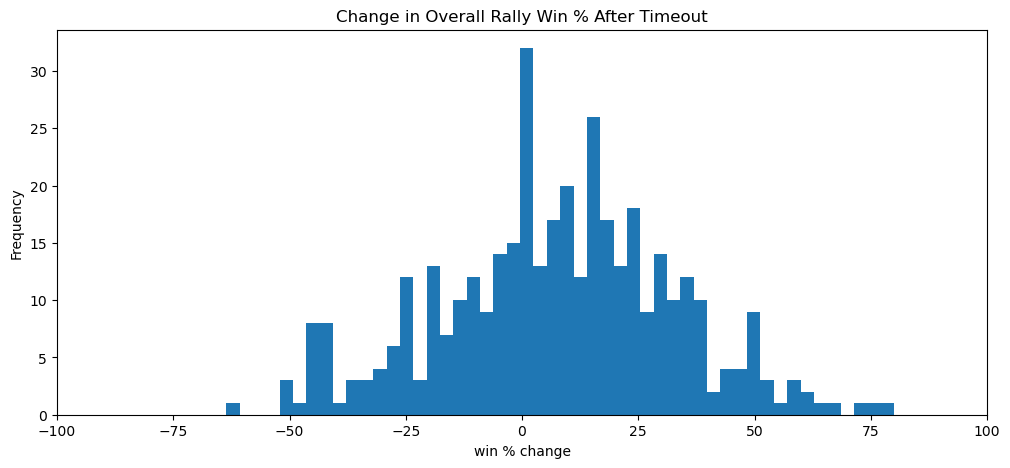

In [141]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.hist(df_timeout.deltawin, bins=50)
plt.gca().set(title='Change in Overall Rally Win % After Timeout',xlim=[-100,100], xlabel = 'win % change', ylabel='Frequency');

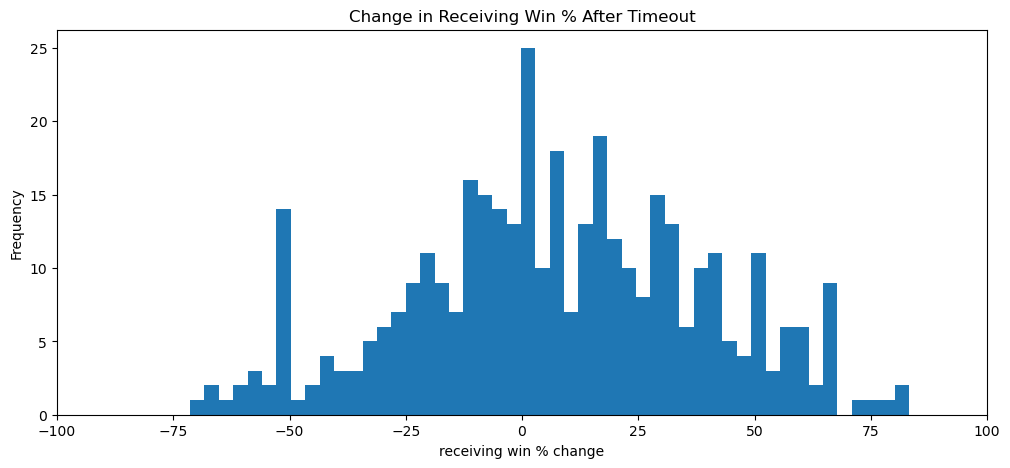

In [72]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.hist(df_timeout.deltawinrcv, bins=50)
plt.gca().set(title='Change in Receiving Win % After Timeout', xlim=[-100,100],xlabel = 'receiving win % change', ylabel='Frequency');

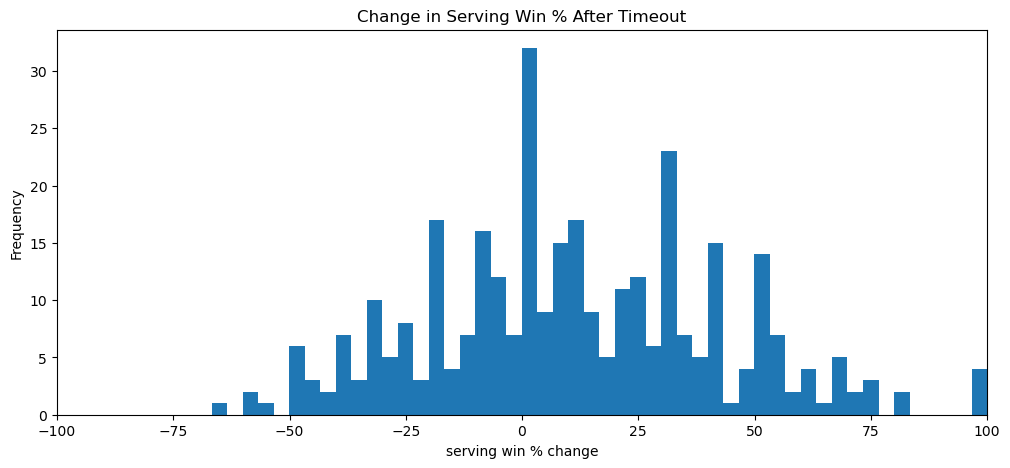

In [73]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.hist(df_timeout.deltawinsrv, bins=50)
plt.gca().set(title='Change in Serving Win % After Timeout', xlim=[-100,100],xlabel = 'serving win % change', ylabel='Frequency');

## Group plots by skill level

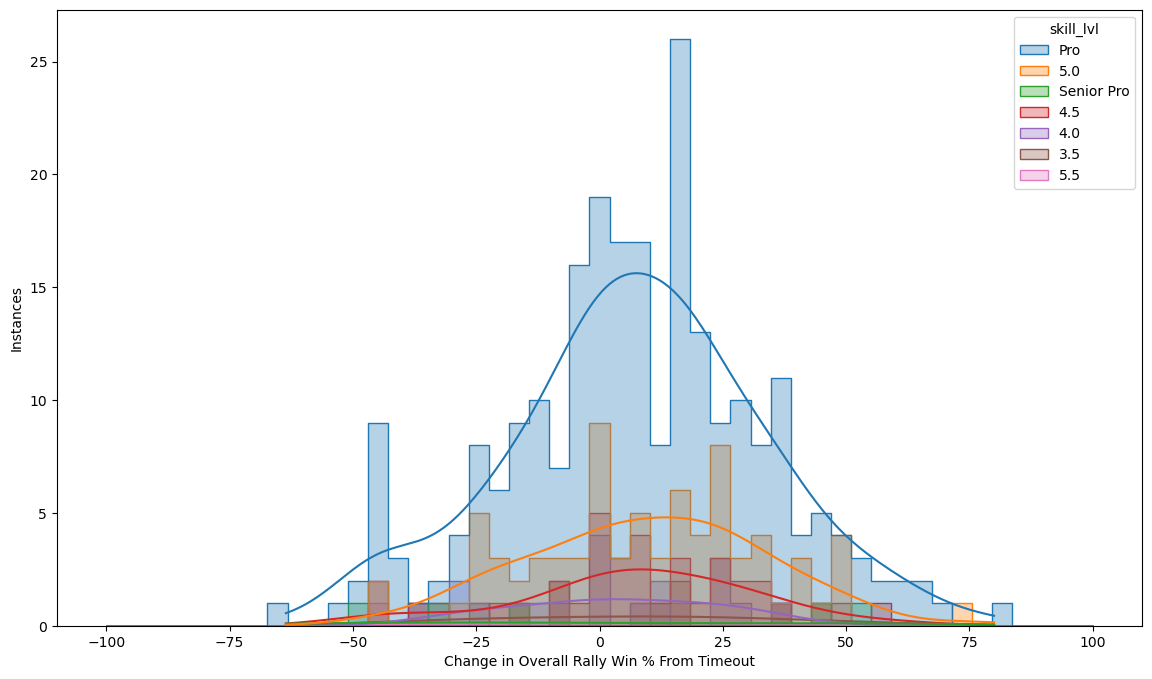

In [142]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = np.linspace(-100, 100, 50)
p = sns.histplot(x="deltawin",data=df_timeout,hue="skill_lvl",bins=HIST_BINS,stat="count",alpha=.33,kde=True,\
             common_norm=True,discrete=False,common_bins=True,fill=True,element='step',multiple='layer')
p.set_xlabel("Change in Overall Rally Win % From Timeout",fontsize=10)
p.set_ylabel("Instances",fontsize=10)
plt.show()

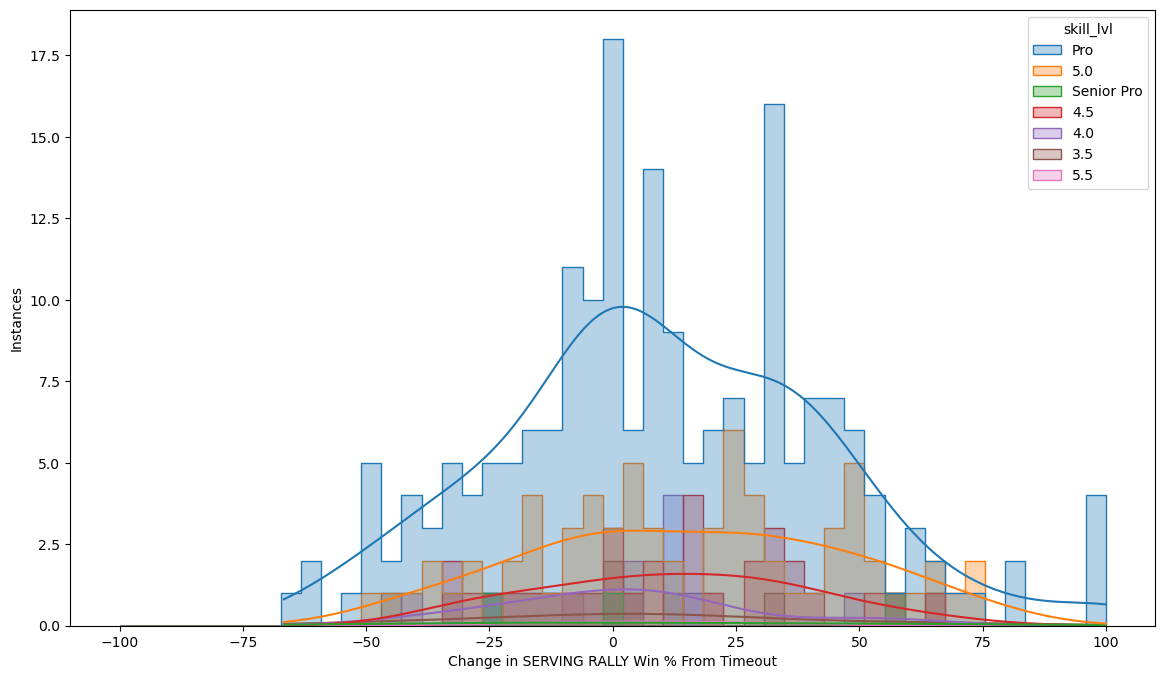

In [78]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = np.linspace(-100, 100, 50)
p = sns.histplot(x="deltawinsrv",data=df_timeout,hue="skill_lvl",bins=HIST_BINS,stat="count",alpha=.33,kde=True,\
             common_norm=True,discrete=False,common_bins=True,fill=True,element='step',multiple='layer')
p.set_xlabel("Change in SERVING RALLY Win % From Timeout",fontsize=10)
p.set_ylabel("Instances",fontsize=10)
plt.show()

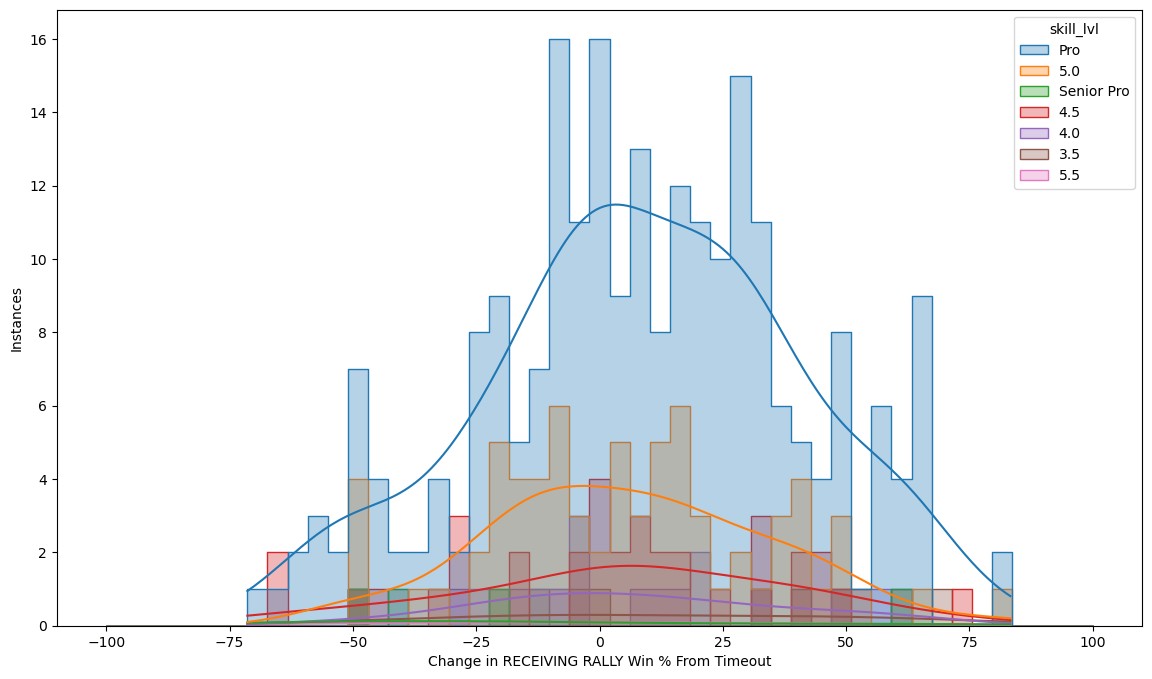

In [79]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = np.linspace(-100, 100, 50)
p = sns.histplot(x="deltawinrcv",data=df_timeout,hue="skill_lvl",bins=HIST_BINS,stat="count",alpha=.33,kde=True,\
             common_norm=True,discrete=False,common_bins=True,fill=True,element='step',multiple='layer')
p.set_xlabel("Change in RECEIVING RALLY Win % From Timeout",fontsize=10)
p.set_ylabel("Instances",fontsize=10)
plt.show()

In [29]:
df_pro=df_timeout[df_timeout.skill_lvl == 'Pro']
df_senpro=df_timeout[df_timeout.skill_lvl == 'Senior Pro']
df_35=df_timeout[df_timeout.skill_lvl == '3.5']
df_40=df_timeout[df_timeout.skill_lvl == '4.0']
df_45=df_timeout[df_timeout.skill_lvl == '4.5']
df_50=df_timeout[df_timeout.skill_lvl == '5.0']
df_55=df_timeout[df_timeout.skill_lvl == '5.5']
skilldata=[list(x.deltawin) for x in [df_35,df_40,df_45,df_50,df_55,df_pro,df_senpro,df_timeout]]
skilldatasrv=[list(x['deltawinsrv'][~pd.isna(x.deltawinsrv)]) for x in [df_35,df_40,df_45,df_50,df_55,df_pro,df_senpro,df_timeout]]
skilldatarcv=[list(x['deltawinrcv'][~pd.isna(x.deltawinrcv)] )for x in [df_35,df_40,df_45,df_50,df_55,df_pro,df_senpro,df_timeout]]

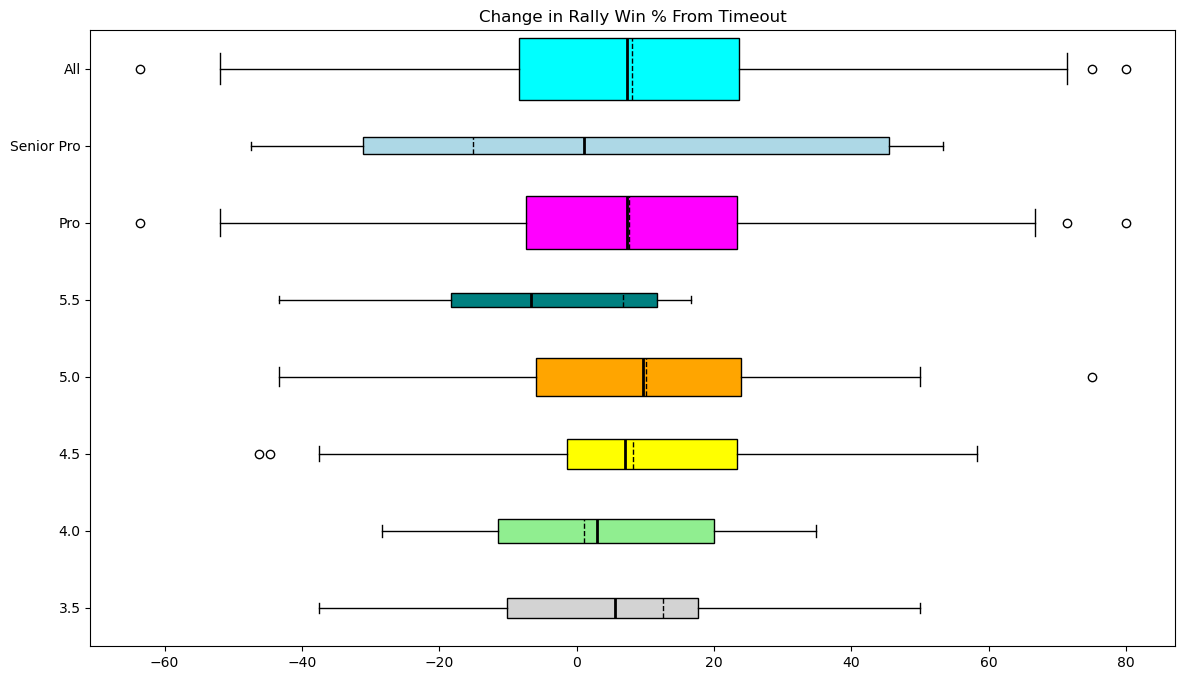

In [30]:
fig, ax = plt.subplots(figsize=(14, 8))
meanlineprops = dict(linestyle='-', linewidth=2.0, color='black')
medianlineprops = dict(linestyle='--', linewidth=1.0, color='black')

plt.title("Change in Rally Win % From Timeout")
# Define widths for boxplots as 0.8 of the normalized sample size
sample_sizes=[len(skilldata[x]) for x in range(len(skilldata))]
widths = [.8*(s / max(sample_sizes))**.3 for s in sample_sizes]

box = plt.boxplot(skilldata,widths=widths,autorange=True,vert=0,patch_artist=True,showmeans=True,medianprops=medianlineprops,\
                  meanline=True,meanprops=meanlineprops,labels=['3.5','4.0','4.5','5.0','5.5','Pro','Senior Pro','All'])

colors = ['lightgrey','lightgreen','yellow','orange','teal','magenta','lightblue','cyan']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

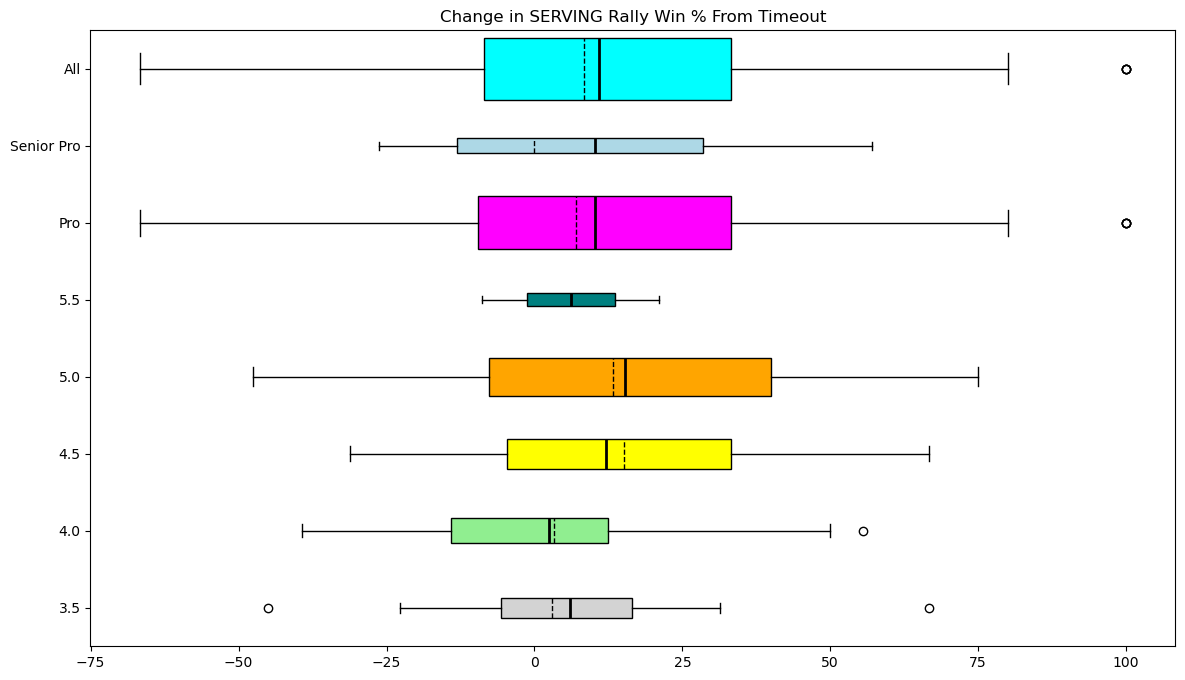

In [31]:
fig, ax = plt.subplots(figsize=(14, 8))
meanlineprops = dict(linestyle='-', linewidth=2.0, color='black')
medianlineprops = dict(linestyle='--', linewidth=1.0, color='black')

plt.title("Change in SERVING Rally Win % From Timeout")
sample_sizes=[len(skilldatasrv[x]) for x in range(len(skilldatasrv))]
widths = [.8*(s / max(sample_sizes))**.3 for s in sample_sizes]

box = plt.boxplot(skilldatasrv,widths=widths,autorange=True,vert=0,patch_artist=True,showmeans=True,medianprops=medianlineprops,\
                  meanline=True,meanprops=meanlineprops,labels=['3.5','4.0','4.5','5.0','5.5','Pro','Senior Pro','All'])

colors = ['lightgrey','lightgreen','yellow','orange','teal','magenta','lightblue','cyan']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

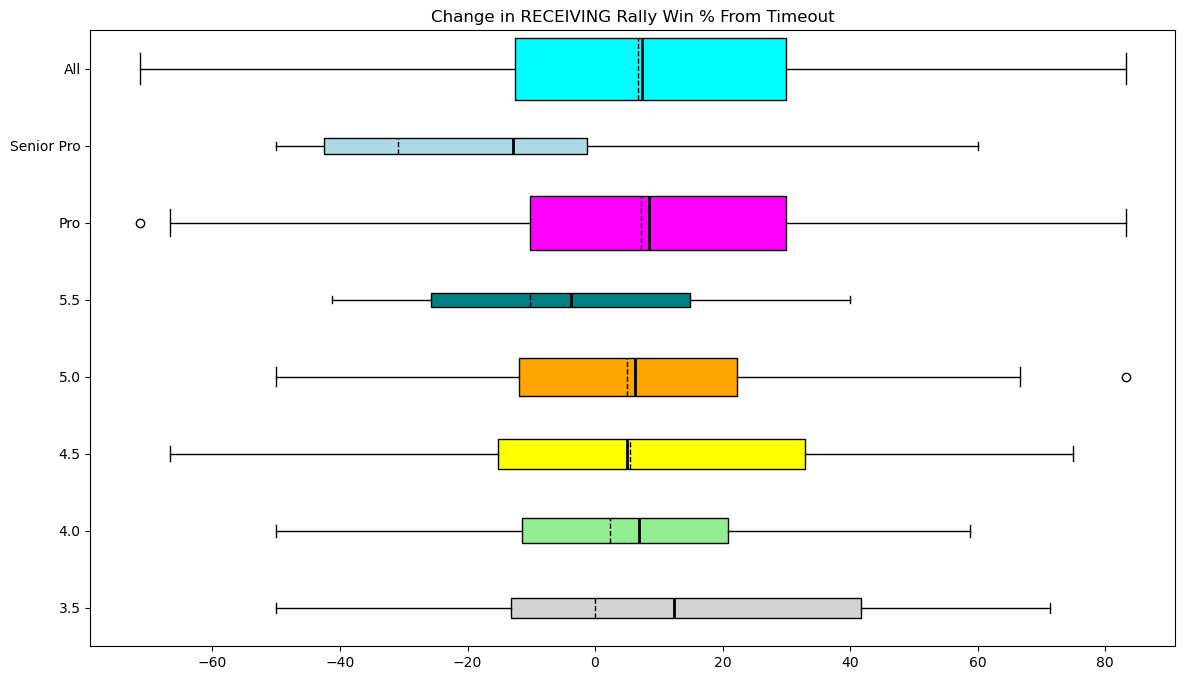

In [32]:
fig, ax = plt.subplots(figsize=(14, 8))
meanlineprops = dict(linestyle='-', linewidth=2.0, color='black')
medianlineprops = dict(linestyle='--', linewidth=1.0, color='black')

plt.title("Change in RECEIVING Rally Win % From Timeout")
sample_sizes=[len(skilldatarcv[x]) for x in range(len(skilldatarcv))]
widths = [.8*(s / max(sample_sizes))**.3 for s in sample_sizes]

box = plt.boxplot(skilldatarcv,widths=widths,autorange=True,vert=0,patch_artist=True,showmeans=True,medianprops=medianlineprops,\
                  meanline=True,meanprops=meanlineprops,labels=['3.5','4.0','4.5','5.0','5.5','Pro','Senior Pro','All'])

colors = ['lightgrey','lightgreen','yellow','orange','teal','magenta','lightblue','cyan']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.show()